In [1]:
import os
import math
import time
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import LambdaLR
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from torchvision import models, transforms
from torch.utils.tensorboard import SummaryWriter
import pandas as pd
import datetime
from tqdm import tqdm
from sklearn.metrics import precision_score, recall_score, f1_score
import numpy as np

# setting device on GPU if available, else CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)
print()

#Additional Info when using cuda
if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
    print('Cached:   ', round(torch.cuda.memory_reserved(0)/1024**3,1), 'GB')

Using device: cuda

Tesla T4
Memory Usage:
Allocated: 0.0 GB
Cached:    0.0 GB


In [2]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
modelname = 'VGG'
# Define the data transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Set the paths for the datasets
base_folder = "/content/drive/My Drive/DSAN6500_Project/TILS_project/data/balanced_dataset"
train_folder = os.path.join(base_folder, "train")
test_folder = os.path.join(base_folder, "test")
validation_folder = os.path.join(base_folder, "valid")

In [4]:
# Create datasets
train_dataset = ImageFolder(root=train_folder, transform=transform)
test_dataset = ImageFolder(root=test_folder, transform=transform)
validation_dataset = ImageFolder(root=validation_folder, transform=transform)

batchsize = 32
numworkers = 4
# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=batchsize, shuffle=True, num_workers=numworkers)
test_loader = DataLoader(test_dataset, batch_size=batchsize, shuffle=False, num_workers=numworkers)
validation_loader = DataLoader(validation_dataset, batch_size=batchsize, shuffle=False, num_workers=numworkers)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [5]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

def train_one_epoch(model, data_loader, criterion, optimizer, device, epoch, num_epochs):
    model.train()
    total_loss = 0.0
    correct_predictions = 0
    total_predictions = 0
    top5_correct = 0
    all_labels = []
    all_predictions = []

    # Update the tqdm description to show current epoch
    for inputs, labels in tqdm(data_loader, desc=f"Epoch {epoch}/{num_epochs} - Training"):
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs, 1)

         # Add top 5 accuracy
        _, top5_predicted = outputs.topk(5,1, True, True)
        top5_correct += top5_predicted.eq(labels.view(-1, 1).expand_as(top5_predicted)).sum().item()

        correct_predictions += (predicted == labels).sum().item()
        total_predictions += labels.size(0)

        all_labels.extend(labels.cpu().numpy())
        all_predictions.extend(predicted.cpu().numpy())

    avg_loss = total_loss / len(data_loader.dataset)
    accuracy = accuracy_score(all_labels, all_predictions)
    top5_accuracy = top5_correct / total_predictions
    precision = precision_score(all_labels, all_predictions, average='macro', zero_division=0)
    recall = recall_score(all_labels, all_predictions, average='macro', zero_division=0)
    f1 = f1_score(all_labels, all_predictions, average='macro', zero_division=0)

    return avg_loss, accuracy, top5_accuracy, precision, recall, f1

In [6]:
def evaluate(model, data_loader, criterion, device, epoch, num_epochs, phase='Validation'):
    model.eval()
    total_loss = 0.0
    correct_predictions = 0
    total_predictions = 0
    top5_correct = 0
    all_labels = []
    all_predictions = []

    # Update the tqdm description to show current epoch and phase (Validation or Testing)
    for inputs, labels in tqdm(data_loader, desc=f"Epoch {epoch}/{num_epochs} - {phase}"):
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        total_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs, 1)

        # Add top 5 accuracy
        _, top5_predicted = outputs.topk(5,1, True, True)
        top5_correct += top5_predicted.eq(labels.view(-1, 1).expand_as(top5_predicted)).sum().item()


        correct_predictions += (predicted == labels).sum().item()
        total_predictions += labels.size(0)

        all_labels.extend(labels.cpu().numpy())
        all_predictions.extend(predicted.cpu().numpy())

    avg_loss = total_loss / len(data_loader.dataset)
    accuracy = accuracy_score(all_labels, all_predictions)
    top5_accuracy = top5_correct / total_predictions
    precision = precision_score(all_labels, all_predictions, average='macro', zero_division=0)
    recall = recall_score(all_labels, all_predictions, average='macro', zero_division=0)
    f1 = f1_score(all_labels, all_predictions, average='macro', zero_division=0)

    return avg_loss, accuracy, top5_accuracy, precision, recall, f1

In [7]:
# VGG Model
output_folder = "/content/drive/My Drive/DSAN6500_Project/TILS_project/results/VGG"

# Load and modify the pretrained VGG model
model = models.vgg16(pretrained=True)
model.classifier[6] = nn.Linear(model.classifier[6].in_features, 150)
model.to(device)

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

# Learning rate scheduler
num_epochs = 50
scheduler = LambdaLR(optimizer, lr_lambda=lambda epoch: 0.1**(epoch // 30))

writer = SummaryWriter('/content/drive/My Drive/DSAN6500_Project/TILS_project/results/VGG/runs')

# Initialize DataFrame to store metrics
columns = [
    'Epoch', 'Training Loss', 'Validation Loss', 'Test Loss',
    'Training Accuracy', 'Validation Accuracy', 'Test Accuracy',
    'Training Precision', 'Training Recall', 'Training F1-Score',
    'Validation Precision', 'Validation Recall', 'Validation F1-Score',
    'Test Precision', 'Test Recall', 'Test F1-Score',
    'Epoch Duration', 'Training Top-5 Accuracy', 'Validation Top-5 Accuracy', 'Test Top-5 Accuracy'
]
df = pd.DataFrame(columns=columns)

best_val_accuracy = 0  # Initialize best validation accuracy for checkpointing

for epoch in range(1, num_epochs + 1):
    start_time = time.time()

    # Assuming you have defined these functions
    train_loss, train_accuracy, train_prec, train_rec, train_f1, train_top5_acc = train_one_epoch(
        model, train_loader, criterion, optimizer, device, epoch, num_epochs)

    val_loss, val_accuracy, val_prec, val_rec, val_f1, val_top5_acc = evaluate(
        model, validation_loader, criterion, device, epoch, num_epochs, phase='Validation')

    test_loss, test_accuracy, test_prec, test_rec, test_f1, test_top5_acc = evaluate(
        model, test_loader, criterion, device, epoch, num_epochs, phase='Testing')

    epoch_duration = time.time() - start_time
    scheduler.step()

    # Log to TensorBoard
    writer.add_scalars('Loss', {'Train': train_loss, 'Validation': val_loss, 'Test': test_loss}, epoch)
    writer.add_scalars('Accuracy', {'Train': train_accuracy, 'Validation': val_accuracy, 'Test': test_accuracy}, epoch)
    writer.add_scalars('Precision', {'Train': train_prec, 'Validation': val_prec, 'Test': test_prec}, epoch)
    writer.add_scalars('Recall', {'Train': train_rec, 'Validation': val_rec, 'Test': test_rec}, epoch)
    writer.add_scalars('F1-Score', {'Train': train_f1, 'Validation': val_f1, 'Test': test_f1}, epoch)
    writer.add_scalars('Top-5 Accuracy', {'Train': train_top5_acc, 'Validation': val_top5_acc, 'Test': test_top5_acc}, epoch)

    # Update DataFrame
    new_row = {
        'Epoch': epoch + 1, 'Training Loss': train_loss, 'Validation Loss': val_loss, 'Test Loss': test_loss,
        'Training Accuracy': train_accuracy, 'Validation Accuracy': val_accuracy, 'Test Accuracy': test_accuracy,
        'Training Precision': train_prec, 'Training Recall': train_rec, 'Training F1-Score': train_f1,
        'Validation Precision': val_prec, 'Validation Recall': val_rec, 'Validation F1-Score': val_f1,
        'Test Precision': test_prec, 'Test Recall': test_rec, 'Test F1-Score': test_f1,
        'Epoch Duration': epoch_duration, 'Training Top-5 Accuracy': train_top5_acc, 'Validation Top-5 Accuracy': val_top5_acc,
        'Test Top-5 Accuracy': test_top5_acc
    }
    df = pd.concat([df, pd.DataFrame([new_row])], ignore_index=True)

    # Checkpointing
    if val_accuracy > best_val_accuracy:
        best_val_accuracy = val_accuracy
        torch.save(model.state_dict(), os.path.join(output_folder, 'vgg_best.pth'))

writer.close()

# Save the DataFrame to a CSV file
timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
csv_filename = f"vgg_training_results_{timestamp}.csv"
df.to_csv(os.path.join(output_folder, csv_filename), index=False)


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:08<00:00, 65.6MB/s]
Epoch 1/50 - Training:   0%|          | 0/2 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total.

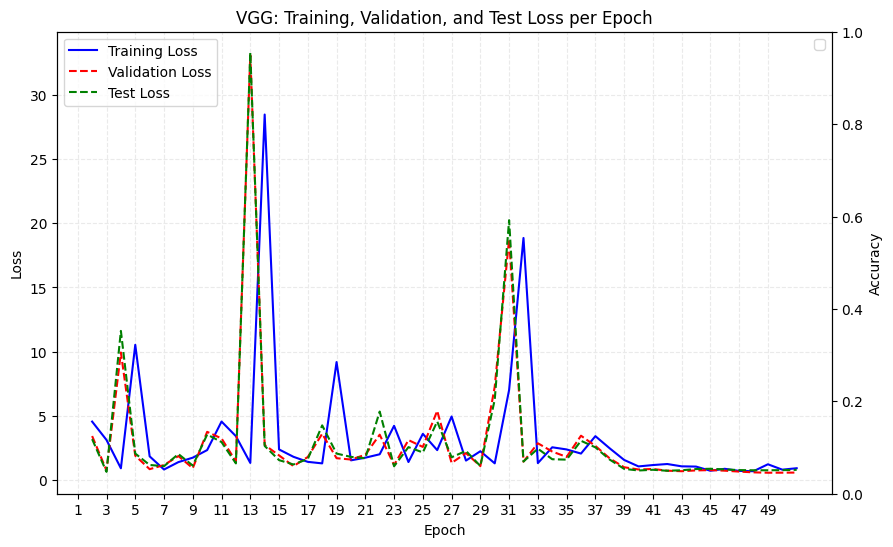

In [9]:
import matplotlib.pyplot as plt

# Ensure 'Test Loss' and 'Validation Loss' are present in your DataFrame
plt.figure(figsize=(10, 6))

# Plot training, test, and validation loss
plt.plot(df['Epoch'], df['Training Loss'], linestyle='-', color='blue', label='Training Loss')
plt.plot(df['Epoch'], df['Validation Loss'], linestyle='--', color='red', label='Validation Loss')
plt.plot(df['Epoch'], df['Test Loss'], linestyle='--', color='green', label='Test Loss')

# Optionally, plot validation and test accuracy if you wish to visualize accuracy on a secondary axis
plt.title('VGG: Training, Validation, and Test Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.xticks(range(1, num_epochs + 1, 2))  # Adjust this based on your actual number of epochs
plt.grid(True, which='both', axis='both', linestyle='--', color="#eaeaea")
plt.legend(loc='upper left')

# Create a secondary y-axis to plot accuracy if needed
sec_axis = plt.twinx()
sec_axis.set_ylabel('Accuracy')
sec_axis.legend(loc='upper right')

plt.savefig(os.path.join(output_folder, f"training_validation_test_loss_plot_{modelname}_{timestamp}.png"), dpi=300)  # Save the plot as a PNG file
plt.show()